This notebook has been designed to strengthen one's understanding of how one numerically constructs a stellar structure by simply using a polytropic equation of state with the appropriate index. Before we dive into the physics and the illustrations, we need to import the necessary python packages

In [31]:
# This block will simply check for any missing python modules and will quietly install them within the Jupyter container.
# No packages will be installed within your actual python directory, so if you have any packages setup in a given way,
# they will not be overwritten
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib','ipython','scipy','tabulate'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])
#The necessary libraries are imported here
import tabulate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.integrate import odeint

In simple terms, the polytropic equation of state is a power-law relation between the pressure (P) and the density $(\rho)$. Algebraically, the relation can be written down as $$P = K\rho^{1+1/n}$$ where n is the polytropic index. By manipulating the hydrostatic equilibrium, mass continuity, and Poisson equations and introducing a dimensionless variables, we arrive at a second order differential equation called the Lane-Emden equation $$\frac{1}{\xi^2}\frac{d}{d\xi}\left(\xi^2\frac{d\theta_n}{d\xi}\right) = -\theta_n^n$$ Full derivation of the Lane-Emden equation is provided here. The $\theta_n(\xi)$ is known as the Lane-Emden solution of index n, or polytrope of index n. The P and $\rho$ can now be calculated by via $P = P_c\theta_n^{n+1}$ and $\rho = \rho_c\theta_n^n$; the subscript is to note the order and the exponent is for the power law. From the forms of the pressure and density, we expect them to have their central values at the stars center and zero at the surface. Hence, the boundary conditions for the Lane-Emden equation are $\theta_n(0) = 1$, $\theta'_n(0) = 0$, and $\theta_n(\xi_1) = 0$, where $\xi_1$ is the (first) root of the polytrope.

To solve the Lane-Emden equation, we split it into 2 first order differential equations:$$\frac{d\theta}{d\xi} = -\frac{\phi}{\xi^2}$$ $$\frac{d\phi}{d\xi}=\theta^n\xi^2$$ and feed it into the solver with the aforementioned boundary conditions

The 1st of the following functions will feed into the ODE integrater, while the second will determine the root of the polytrope

In [32]:
def odes(y,t,n): #sets up the 2 1st order ODEs to be solved
    v = np.zeros(2)
    if t==0:
        v[0] = 0 #avoids the NaN at the boundary condition and rewriting the 1st order ODEs will produce garbage
    else:
        v[0] = -y[1]/t**2 #1st equation
    v[1] = np.power(y[0],n)*np.power(t,2)#2nd equation
    
    
    return v
def newton_raphson(x,y,dy,x0,j,n):
#Since we don't have an explicit function, we need to interpolate the arrays at every new "root" 
#until the method converges
    if n>=5:
        x0 = np.infty
        return x0
    h = y[j]/dy[j]
    while abs(h)>=1e-10:
        x0-=h
        y0 = np.interp(x0,x,y)
        dy0 = np.interp(x0,x,dy)
        h = y0/dy0
    
    return x0

In [52]:
init_con = [1,0] #initial conditions
theta_n = np.empty((300,6)) #2D array to store the polytropes over 300 points
xi_1 = np.empty(6)
table = np.empty((6,3)) # to be tabulated at end of graph

for i in range(0,6): #loops over integer polytropic indices from 0 to 5
    if i == 2:# this is necessary to cut off for order 2 as the solver diverges 
              #to positive infty when as the solution itself diverges to -infty 
        xi = np.linspace(0,10,300)
    else:
        xi = np.linspace(0,20,300)
    theta_n[:,i] = odeint(odes,init_con,xi,(i,))[:,0]    
    d_theta_n = np.gradient(theta_n[:,i],xi)
    j = 0 #resets the index
    for j in range(len(xi)):#search for the best guess to plug in the Newton Raphson method, else would diverge
        if theta_n[j,i] <0:
            break
    
    xi_1[i] = newton_raphson(xi,theta_n[:,i],d_theta_n,xi[j-1],j-1,i) #the root
    d_theta_xi_1 = np.abs(np.interp(xi_1[i],xi,d_theta_n))#derivative at the root
    table[i] = [i,xi_1[i],np.power(xi_1[i],2)*d_theta_xi_1]
    if i==5:
        table[i] = [i,xi_1[i],np.sqrt(3)] #analytical model

Setting up the plot properties and table

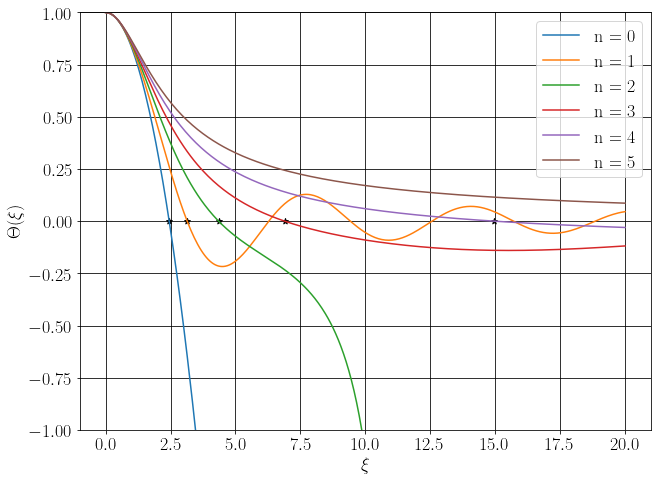

<IPython.core.display.Math object>

0,2.44927,4.89766
1,3.14164,3.14058
2,4.35291,2.41124
3,6.89692,2.01848
4,14.9716,1.79728
5,inf,1.73205


In [53]:
plt.figure(figsize=(10.24,7.68))
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\Theta(\xi)$')
plt.ylim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18
plt.grid(color = 'black')
for i in range(6):
    if i == 2:
        xi = np.linspace(0,10,300)
        plt.plot(xi,theta_n[:,i],label='n = '+str(i))
    else:
        xi = np.linspace(0,20,300)
        plt.plot(xi,theta_n[:,i],label='n = '+str(i))
    
plt.scatter(xi_1,np.zeros(len(xi_1)),marker = '*',color='black')

plt.legend()
plt.show()
display(Math(r'n  \;\;\;\;\;  \xi_{1}   \;\;\;\;\; -\xi_{1}^{2}\frac{d\theta}{d\xi}\Bigr|_{\xi=\xi_{1}}'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The Lane-Emden equation itself admits 3 analytical solutions at indices 0,1, and 5 and have the following forms $$\theta_0(\xi) = 1 - \frac{\xi^2}{6}; \xi_1 = \sqrt6$$ $$\theta_1(\xi) = \frac{sin(\xi)}{\xi}; \xi_1 = \pi$$ $$\theta_5(\xi) = \frac{1}{\sqrt{ \left( 1+\frac{\xi^2}{3} \right)} }; \xi_1 \rightarrow \infty$$
Detailed derivation can be found [here]()

Now let's take what we've studied so far and apply it to a physical proble. We will consider 2 scenarios.

In the first scenario, let's say we wish to determine how well a polytrope of index 3 can describe the profiles in the of a main sequence star. We need to supply the total mass, total radius, and index. For this example, we shall take the sun. We can use the surface properties of the sun(mass and radius) to determine central pressure and density, along with the constant of proportionality K and the scale length. The formulas can be easily derived and are as follows: $$P_c = \frac{8.952e+14}{(n+1)(\theta'_{n})^2_{\xi_1}}\left(\frac{M}{M_\odot}\right)^2\left(\frac{R}{R_\odot}\right)^{-4}dyne.cm^{-2}$$ $$K = \frac{G}{n+1}M^{1-1/n}R^{-1+3/n}\left(\frac{4\pi}{\xi_1^{n+1}(-\theta'_n\Bigr|_{\xi_1})^{n-1}}\right)^{1/n}$$ $$\rho_c = \left(\frac{P_c}{K}\right)^{\frac{n}{n+1}} g/cc$$ $$r_n = \sqrt{\frac{(n+1)P_c}{4\pi G\rho_c^2}}$$

In [54]:
n = 3 #polytropic index
M = 1.0 #total mass in solar masses
R = 1.0#total radius in terms of solar radius

m_sun = 1.989e+33 #grams
r_sun = 6.957e+10 #cm
G = 6.67408e-8    #dyne.(cm/g)^2

#Calculating the polytrope and it's properties
xi = np.linspace(0,20,300)
theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
for i in range(len(theta_n)):
    if theta_n[i]<0:
        break
d_theta_n = np.gradient(theta_n,xi) #derivative array
xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

#calculating K
term1 = G/(n+1)
term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
term3 = 4*np.pi
term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
K = term1*term2*np.power(term3/term4,1/n)

#Calculating the central pressure
term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
term2 = (n+1)*np.power(d_theta_xi_1,2)
P_c   = term1/term2 #dyne/cm^2
#Calculating central density
rho_c = np.power(P_c/K,n/(n+1))
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)


Now that the terms are defined, we simply calculate the pressure and density by $$P = P_c\theta_n^{n+1}$$ $$\rho = \rho_c\theta_n^n$$ The mass can be integrated from the continuity equation $$M(\xi) = 4\pi r_n^3 \rho_c (-\xi^2\theta'_n\Bigr|_\xi)$$ Bear in mind that the subscript 'n' indicates the polytropic index

In [55]:
#since we only need the values up to the root, we need to trim the arrays

theta_n = theta_n[0:i-1]
xi = xi[0:i-1]
d_theta_n = d_theta_n[0:i-1]

P = P_c*np.power(theta_n,n+1)
rho = rho_c*np.power(theta_n,n)
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
r  = r_n*xi

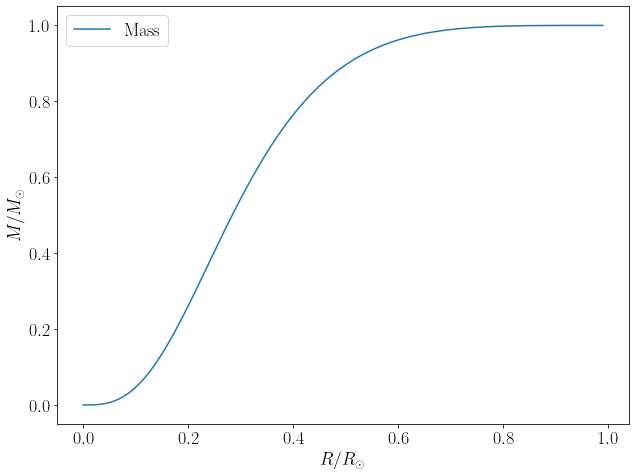

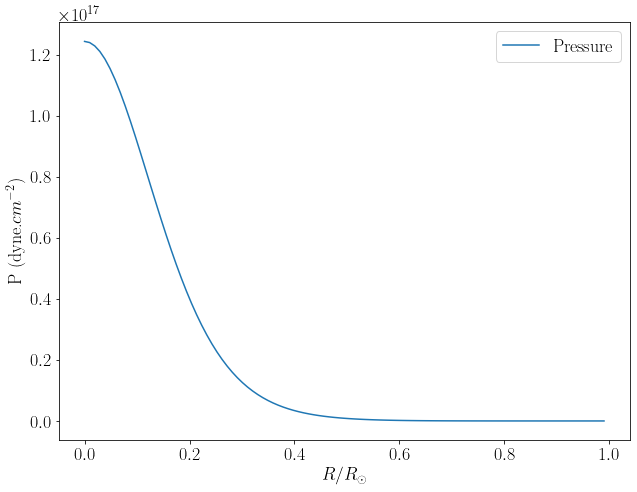

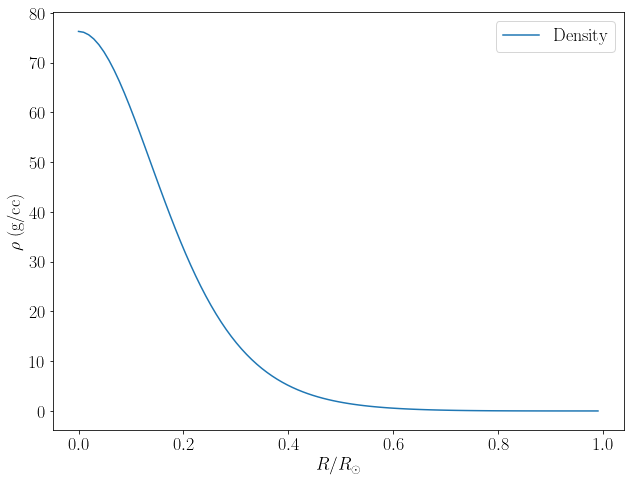

In [56]:
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

Now let's try the problem in a different way. Say we which to determine the properties of a white dwarf of central density $\rho_c = 10^{11} g/cc$, polytropic index 3/2, and K ~ $10^{14}$. We can calculate the total mass and radius of the white dwarf from the properties of the polytrope. The radius is simply $$R = r_n\xi_1$$ and the total mass $$M = -4\pi r_n^3 \rho_c \xi_1^2 \theta'_n\Bigr|_{\xi_1}$$. And from the equation of state itself, we get $$P_c = K\rho_c^{1+1/n}$$

In [57]:
n = 3/2
K = 1e+14
rho_c = 1e+11
#Calculating central pressure
P_c = K*np.power(rho_c,1+1/n)
#length scale
term1 = (n+1)*P_c
term2 = 4*np.pi*G*np.power(rho_c,2)
r_n = np.sqrt(term1/term2)


#Calculating the polytrope and it's properties
xi = np.linspace(0,20,300)
theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
for i in range(len(theta_n)):
    if theta_n[i]<0:
        break
d_theta_n = np.gradient(theta_n,xi) #derivative array
xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

theta_n = theta_n[0:i-1]
xi = xi[0:i-1]
d_theta_n = d_theta_n[0:i-1]

P = P_c*np.power(theta_n,n+1)
rho = rho_c*np.power(theta_n,n)
m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
r  = r_n*xi
#a warning will appear when using fractional indices. This is because the algorithm is trying to take a root of a negative number.
#the algorithm will cut off at the point of inflection

<ipython-input-32-b12578829979>:7: RuntimeWarning: invalid value encountered in power
  v[1] = np.power(y[0],n)*np.power(t,2)#2nd equation


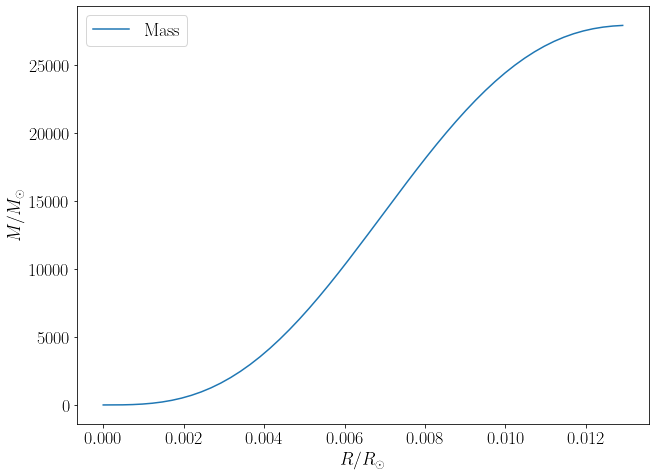

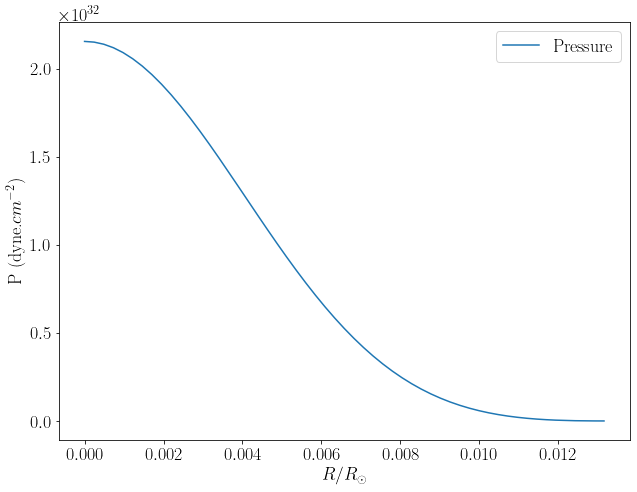

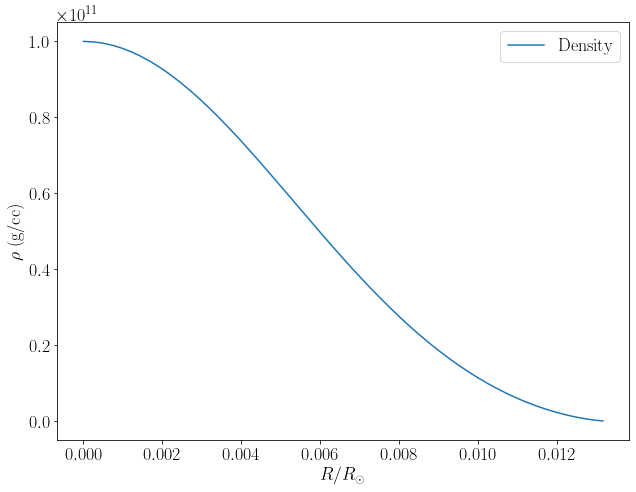

In [58]:
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

Looking at the mass graph, it's obvious we've exceeded the Chandrasekhar limit by a few orders of magnitude. (modeling a black whole structure maybe? (seems far fetched). You go back to the block and see which value of n would give an appropriate distribution (hint: it's an integer less than 5)

If you wish to test around different values for either case, set the appropriate flag to True and supply the values you wish to test. The option to print the data to text file will be available, but commented out if you do not wish to print to file every time you run the block

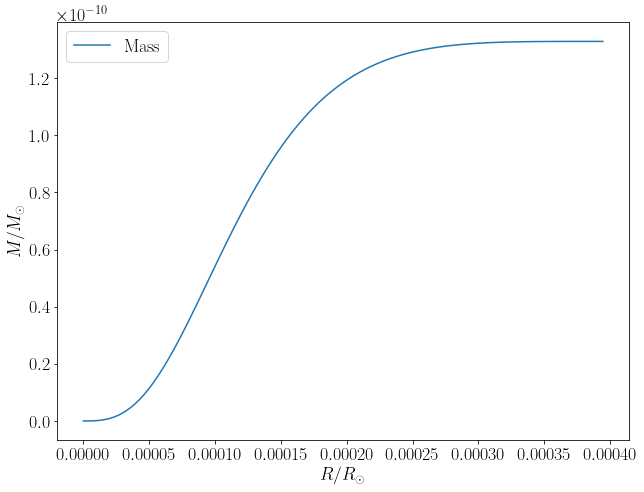

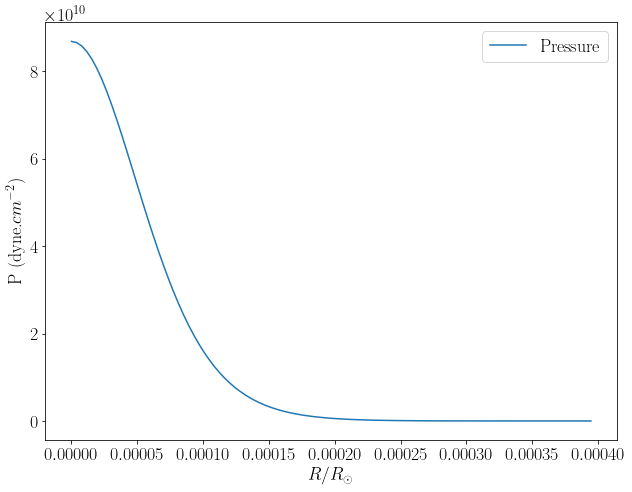

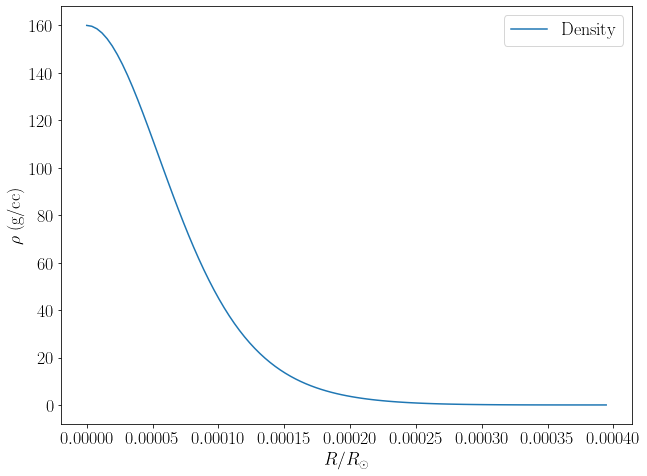

In [59]:
n_K_rho_c = True  #set either marker to true in case you want to supply either the
                  # polytropic index, K and central density, or n, total mass and radius

n     = 3      
K     = 1e+8     
M     = 1.0 #in solar masses
R     = 1.0 #in solar radius
rho_c = 160.0 #in g/cc
# the algorithm will overwrite the appropriate variables depending on the choice you make
if n_K_rho_c:
    #Calculating central pressure
    P_c = K*np.power(rho_c,1+1/n)
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)


    #Calculating the polytrope and it's properties
    xi = np.linspace(0,20,300)
    theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
    for i in range(len(theta_n)):
        if theta_n[i]<0:
            break
    d_theta_n = np.gradient(theta_n,xi) #derivative array
    xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
    d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

    theta_n = theta_n[0:i-1]
    xi = xi[0:i-1]
    d_theta_n = d_theta_n[0:i-1]

    P = P_c*np.power(theta_n,n+1)
    rho = rho_c*np.power(theta_n,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
    r  = r_n*xi
else:
    #Calculating the polytrope and it's properties
    xi = np.linspace(0,20,300)
    theta_n = odeint(odes,init_con,xi,(n,))[:,0] #the initial conditions are the same as before
    for i in range(len(theta_n)):
        if theta_n[i]<0:
            break
    d_theta_n = np.gradient(theta_n,xi) #derivative array
    xi_1 = newton_raphson(xi,theta_n,d_theta_n,xi[i-1],i-1,n) #root
    d_theta_xi_1 =np.abs(np.interp(xi_1,xi,d_theta_n))# derivative at root

    #calculating K
    term1 = G/(n+1)
    term2 = np.power(M*m_sun,1-1/n)*np.power(R*r_sun,-1+3/n)
    term3 = 4*np.pi
    term4 = np.power(xi_1,n+1)*np.power(d_theta_xi_1,n-1)
    K = term1*term2*np.power(term3/term4,1/n)

    #Calculating the central pressure
    term1 = 8.952e+14*np.power(M,2)*np.power(R,-4)
    term2 = (n+1)*np.power(d_theta_xi_1,2)
    P_c   = term1/term2 #dyne/cm^2
    #Calculating central density
    rho_c = np.power(P_c/K,n/(n+1))
    #length scale
    term1 = (n+1)*P_c
    term2 = 4*np.pi*G*np.power(rho_c,2)
    r_n = np.sqrt(term1/term2)

    theta_n = theta_n[0:i-1]
    xi = xi[0:i-1]
    d_theta_n = d_theta_n[0:i-1]

    P = P_c*np.power(theta_n,n+1)
    rho = rho_c*np.power(theta_n,n)
    m = -4*np.pi*np.power(r_n,3)*rho_c*np.power(xi,2)*np.interp(xi,xi,d_theta_n)
    r  = r_n*xi

#graphing    
plt.figure(figsize=(10.24,7.68))

plt.plot(r/r_sun,m/m_sun,label='Mass')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'$M/M_{\odot}$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,P,label='Pressure')
plt.xlabel(r'$R/R_{\odot}$')
plt.ylabel(r'P (dyne.$cm^{-2})$')
plt.legend()
plt.show()

plt.figure(figsize=(10.24,7.68))
plt.plot(r/r_sun,rho,label='Density')
plt.ylabel(r'$\rho$ (g/cc)')
plt.xlabel(r'$R/R_{\odot}$')
plt.legend()
plt.show()

In [60]:
#saving to file. uncomment the lines to save to file
#data = np.column_stack((r,m,P,rho))
#np.savetxt('data.txt',data)